In [92]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

# Names as Arguments
model_name = 'psm_simplified'

training_trajectory_name = 'five'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dof: 7
Fourier order: 6
Base frequency: 0.18


In [93]:

training_trajectory_name = 'one'
results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = '../Downloads/free_train_5_int_psm_simp_yan_6k.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

<class 'numpy.ndarray'> (2456, 23)


In [94]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = '../simon_trocar_feb_27/test_contact/TO_cont_comp_test10_int.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

<class 'numpy.ndarray'> (2202, 21)


0.18
[5.4]
q_raw shape: (2456, 7)
2456
2436
plot shape: 470


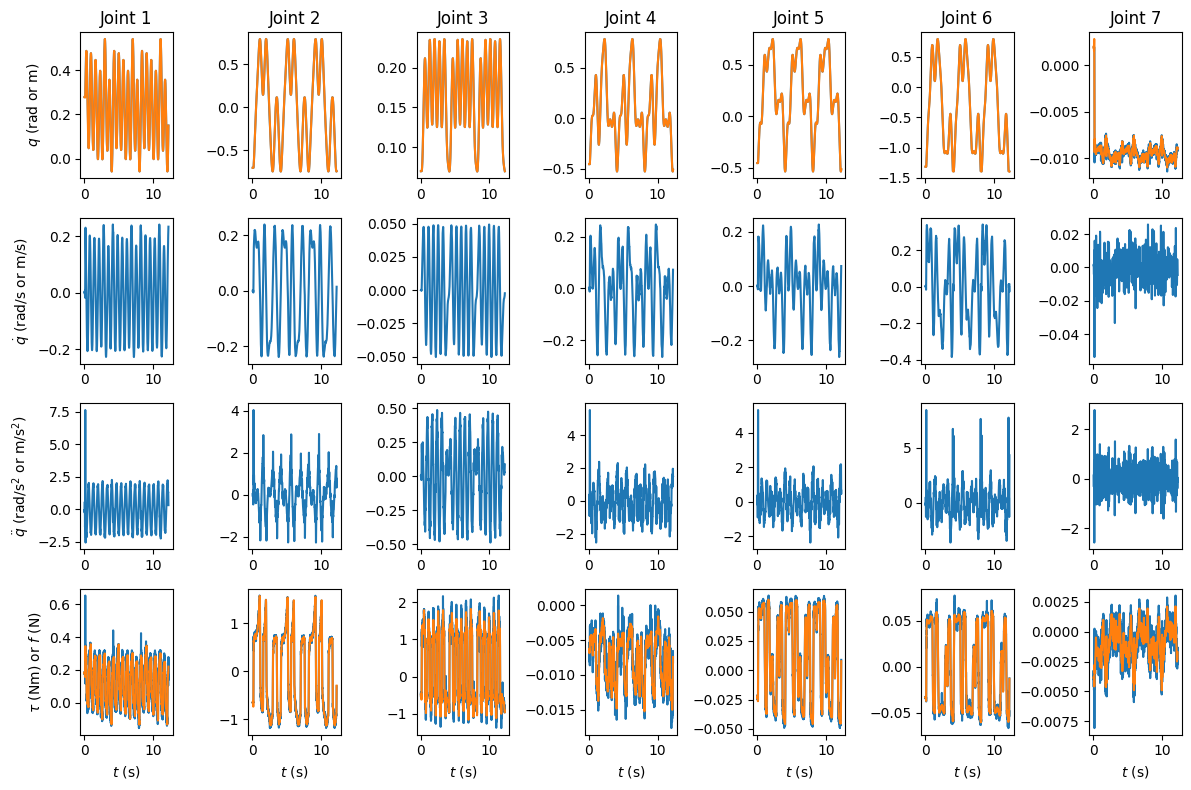

q_raw shape: (2202, 7)
plot shape: 470


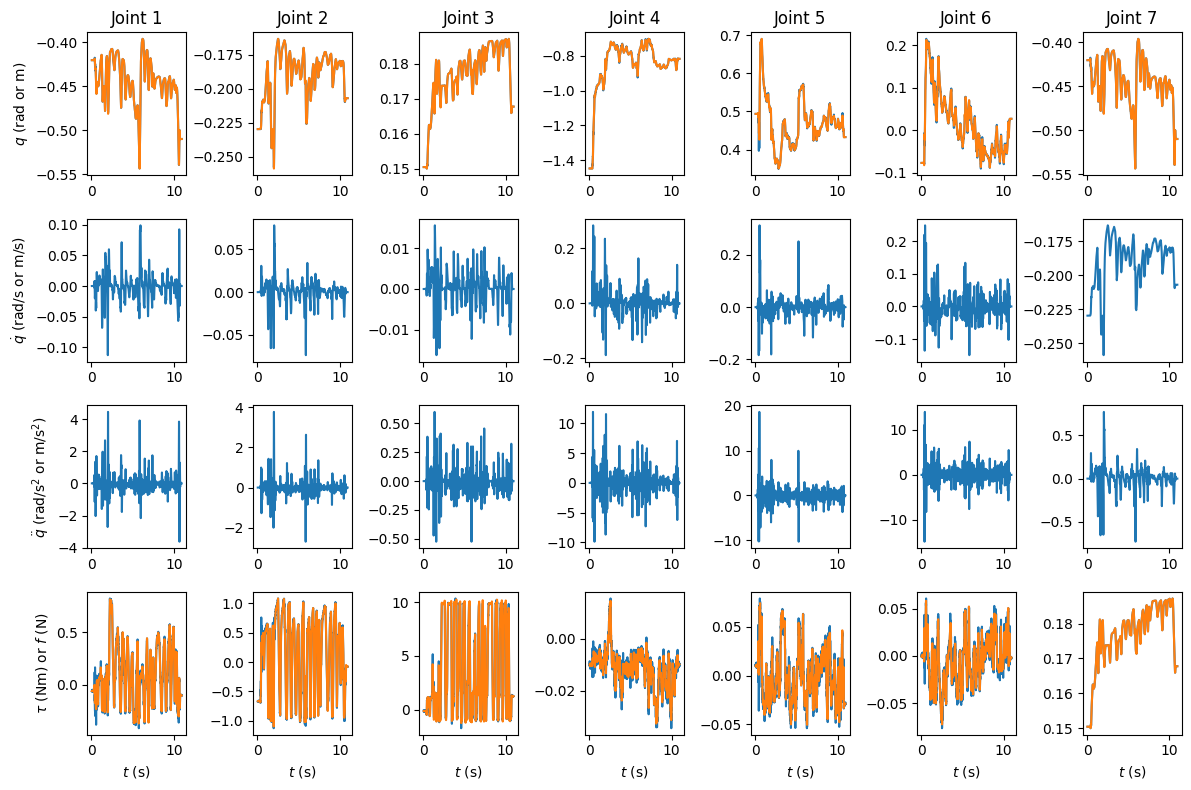

/tmp/ipykernel_13078/4079539031.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]


2436


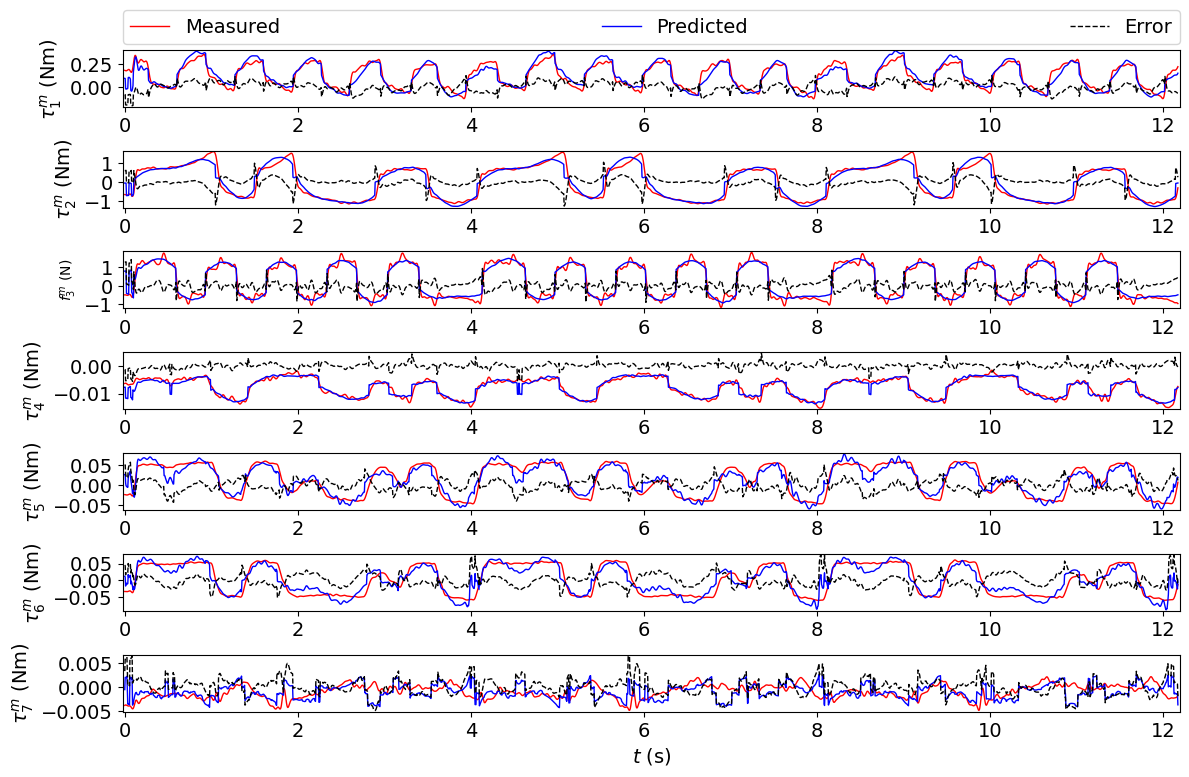

In [95]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)

t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc, cut_num=10)
print(len(tau_raw_train))
print(len(tau_f_train))
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc, cut_num=10)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)

plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
print(len(tau_f_train))
plot_meas_pred_tau(t_cut_train[:], tau_f_train[:, :],
                   tau_p_train[:, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

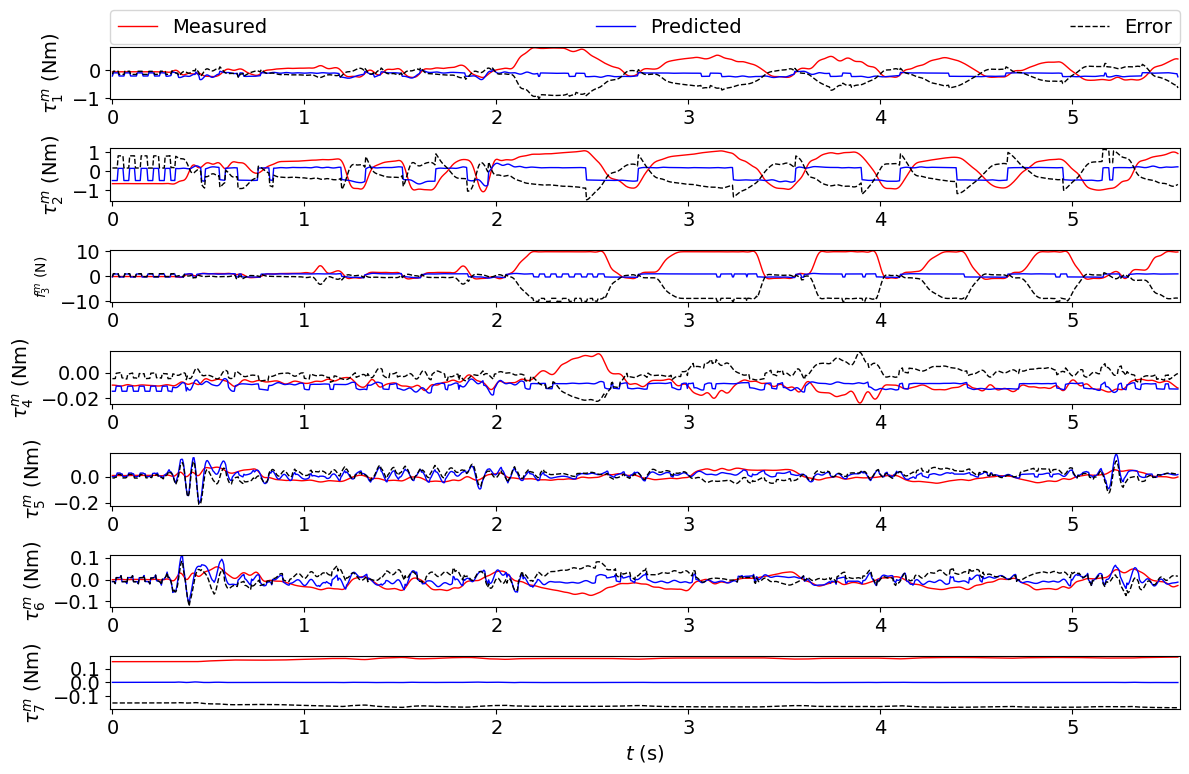

array([1.23783729, 0.8553365 , 0.92251925, 0.56427987, 1.34705627,
       0.92903691, 1.00625463])

In [96]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]
    
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

/tmp/ipykernel_13078/1536028775.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]


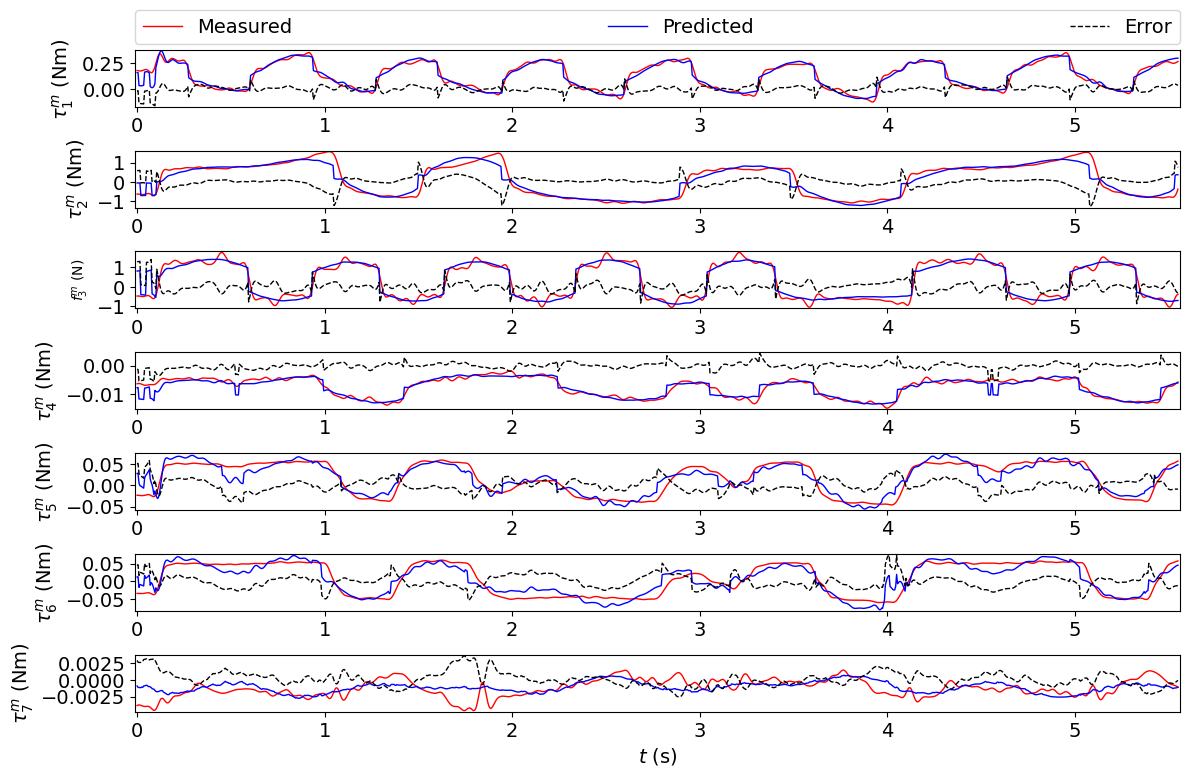

array([0.16681143, 0.30085792, 0.25540418, 0.14124437, 0.34815035,
       0.39851269, 0.6114407 ])

In [97]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
W_b_train.shape, tau_s_train.shape
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, int(W_b_train.shape[0]/weight.shape[0]))
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type, 
                   robot_model.coordinates)
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

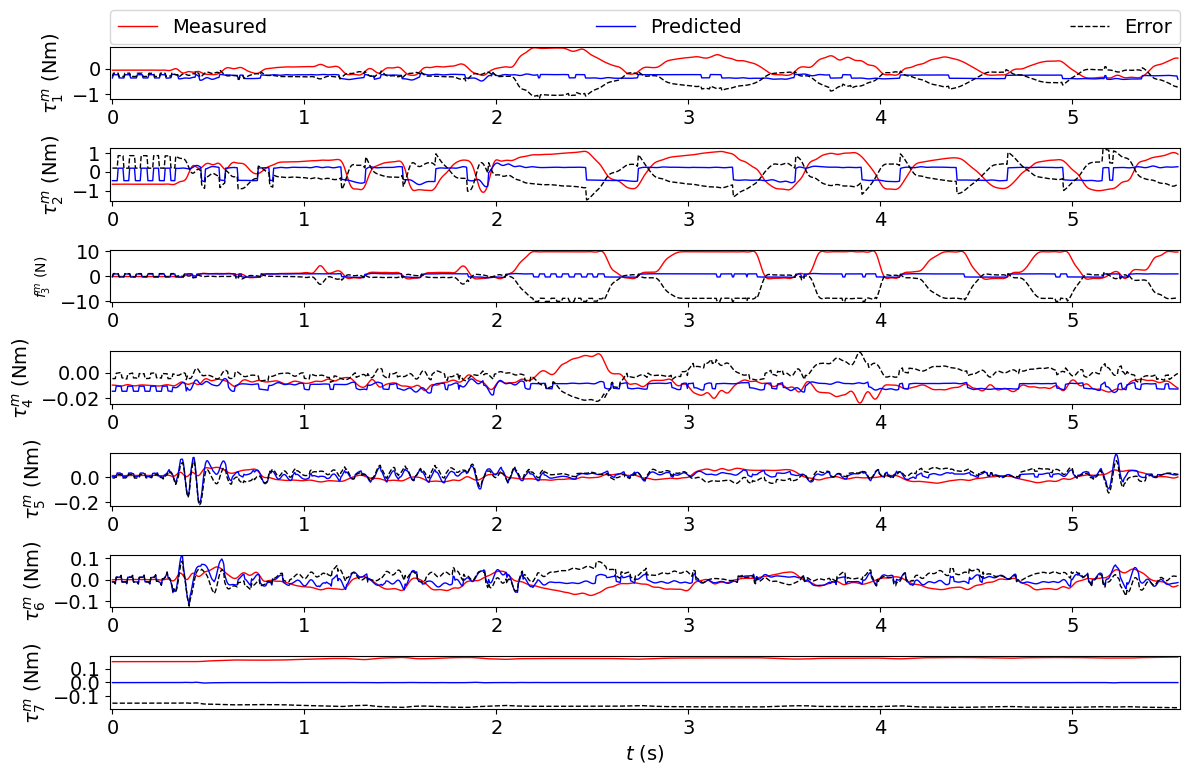

array([1.6024478 , 0.83444642, 0.92115813, 0.56427987, 1.36450754,
       0.92486468, 1.01473222])

In [98]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, int(W_b_test.shape[0]/weight.shape[0]))

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

In [99]:
import os.path
import os
import errno
import cloudpickle
test_plot_data = (t_cut_test[:], tau_f_test[:, :],
                   tau_p_wls_test[:, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

model_file = '../simon_trocar_feb_27/test_contact/' + 'TO_cont_comp_test10' + '.pkl'

if not os.path.exists(os.path.dirname(model_file)):
    try:
        os.makedirs(os.path.dirname(model_file))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

    with open(model_file, 'wb') as f:
        cloudpickle.dump(test_plot_data, f)

In [100]:
# Assuming your tuple is named 'data_tuple'
# The third element of the tuple contains the ndarray
your_ndarray = test_plot_data[2]  # Assuming the ndarray is the third element

reshaped_ndarray = your_ndarray.reshape((-1, 7))

# Define the file name
file_name = '../simon_trocar_feb_27/test_contact/' + 'TO_free_comp_model_pred' + '.csv'

# Save the ndarray as a CSV file
np.savetxt(file_name, reshaped_ndarray, delimiter=' ', fmt='%s')